In [313]:
import xarray as xr
import satpy
import numpy as np
import math
from pyproj import Transformer
import numpy.ma as ma
import datetime
from datetime import datetime, timedelta
import glob
from satpy import Scene
import cartopy.crs as ccrs
import os
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from scipy.ndimage.filters import uniform_filter
import pandas as pd
import matplotlib as mpl

/tmp/ipykernel_524/1502119933.py:15: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter


In [325]:
min_lon = 20
max_lon = 35
min_lat = -18
max_lat = -8

In [332]:
def generate_array(data):

    min_lon = 20
    max_lon = 35
    min_lat = -18
    max_lat = -8
    
    proj = ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831)
    transformer_from_latlon = Transformer.from_crs("EPSG:4326", proj.to_proj4(), always_xy=True)
    
    min_x, max_y = transformer_from_latlon.transform(min_lon, max_lat)
    max_x, min_y = transformer_from_latlon.transform(max_lon, min_lat)
    
    zam = data.sel(nx = slice(min_x, max_x), ny= slice(max_y, min_y))
    
    x_coords = zam.nx.values
    y_coords = zam.ny.values
    
    zam_array = np.flipud(zam['crr_intensity'].values)

    return zam_array, x_coords, y_coords

In [430]:
def nowcast_obs_generator(date, lead_time_mins):

    lead_time_mins = "{0:03d}".format(lead_time_mins)
    nowcast_files = glob.glob('/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/*EXIM*')
    obs_files = glob.glob('/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/*_CRR_*')

    nowcast_files = [file for file in nowcast_files if file[-6:-3] == lead_time_mins]
    
    nowcast_list = []
    obs_list = []
    init_time_list = []
    
    for file in nowcast_files:
        
        init_time = file[-14:-10]
        dt_init_time = datetime.strptime(init_time, '%H%M')
        valid_time = (dt_init_time + timedelta(minutes=int(lead_time_mins))).strftime('%H%M')
        obs_file = '/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_CRR_MSG3_Africa-VISIR_' + date + 'T' + valid_time + '00Z.nc'
        
        try:
            nowcast_data = xr.open_dataset(file)
            obs_data = xr.open_dataset(obs_file)
    
            nowcast_array, x_coords, y_coords = generate_array(nowcast_data)
            obs_array, x_coords, y_coords = generate_array(obs_data)
    
            nowcast_list.append(nowcast_array)
            obs_list.append(obs_array)
    
            init_time_list.append(init_time)
            
        except Exception as e:
            print(e)

    return np.array(nowcasts), np.array(obs), init_time_list

In [ ]:
date = '20240129'
lead_time_mins = 15

nowcasts, obs, init_times = nowcast_obs_generator(date, lead_time_mins)

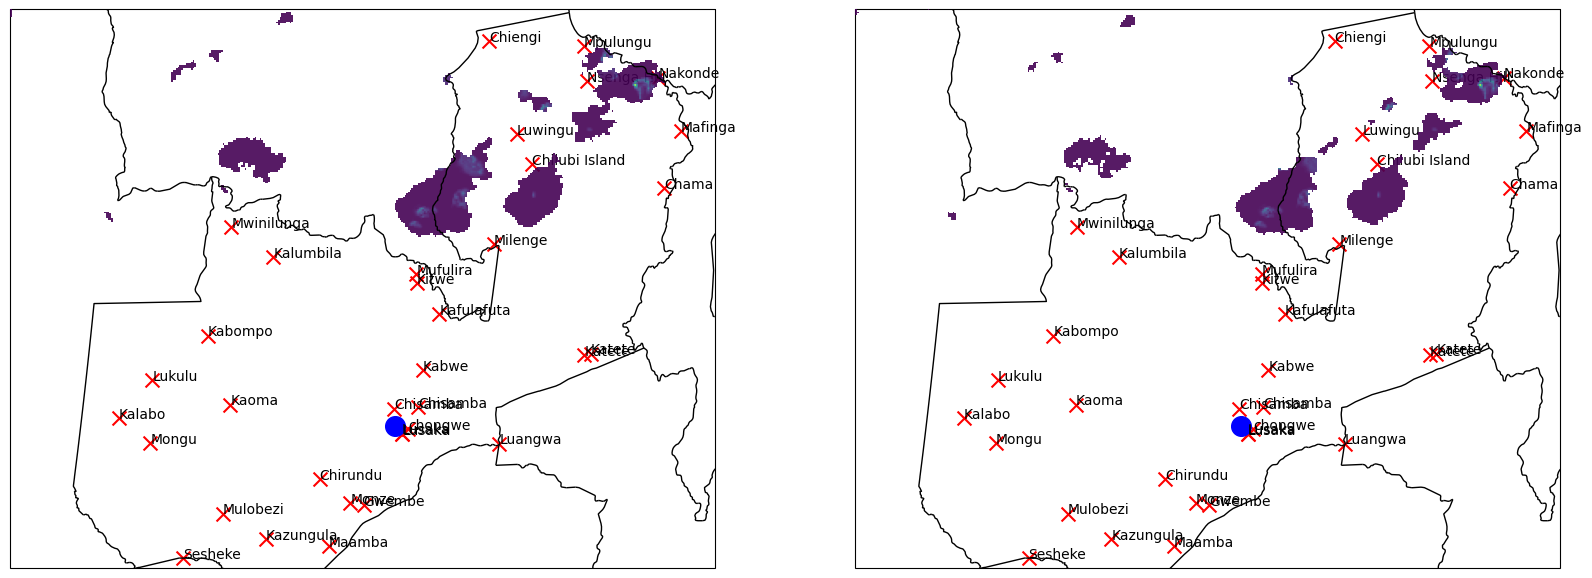

In [433]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))

img = ax.imshow(
    np.where(nowcasts[0]==0,np.nan,crr_array), origin='lower',
    extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
    zorder=10,
    alpha = 0.9
)

##plotting stations and labels
locs = np.load('station_locs.npy')
names = np.load('station_names.npy', allow_pickle=True)

ax.scatter(locs[:,0],locs[:,1],marker='x',c='r',s=100)

for i, txt in enumerate(names):
    ax.annotate(txt, (float(locs[i,0]), float(locs[i,1])))

proj = ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831)
transformer_from_latlon = Transformer.from_crs("EPSG:4326", proj.to_proj4(), always_xy=True)

lusaka_x, lusaka_y = transformer_from_latlon.transform(28.17, -15.25)
ax.scatter(lusaka_x,lusaka_y, c='b',s=200)

ax.add_feature(cfeature.BORDERS, zorder=10)
ax.coastlines(zorder=10)


ax = fig.add_subplot(122,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))

img = ax.imshow(
    np.where(obs[0]==0, np.nan, crr_array), origin='lower',
    extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
    zorder=10,
    alpha = 0.9
)

##plotting stations and labels
locs = np.load('station_locs.npy')
ax.scatter(locs[:,0],locs[:,1],marker='x',c='r',s=100)

for i, txt in enumerate(names):
    ax.annotate(txt, (float(locs[i,0]), float(locs[i,1])))

lusaka_x, lusaka_y = transformer_from_latlon.transform(28.17, -15.25)
ax.scatter(lusaka_x,lusaka_y, c='b',s=200)


ax.add_feature(cfeature.BORDERS, zorder=10)
ax.coastlines(zorder=10)

## Verification

In [434]:
def fss(thr, scale, X_f, X_o):

    if len(X_f.shape) != 2 or len(X_o.shape) != 2 or X_f.shape != X_o.shape:
        message = "X_f and X_o must be two-dimensional arrays"
        message += " having the same shape"
        raise ValueError(message)
    
    # convert nan's to a value below the threshold
    X_f = X_f.copy()
    X_f[~np.isfinite(X_f)] = thr - 1
    X_o = X_o.copy()
    X_o[~np.isfinite(X_o)] = thr - 1

    # Convert to binary fields with the given intensity threshold
    I_f = (X_f >= thr).astype(float)
    I_o = (X_o >= thr).astype(float)

    # Compute fractions of pixels above the threshold within a square
    # neighboring area by applying a 2D moving average to the binary fields
    if scale > 1:
        S_f = uniform_filter(I_f, size=scale, mode="constant", cval=0.0)*(scale)
        S_o = uniform_filter(I_o, size=scale, mode="constant", cval=0.0)*(scale)
    else:
        S_f = I_f
        S_o = I_o

    sum_obs_sq = np.nansum(S_o**2)
    sum_fct_obs = np.nansum(S_f * S_o)
    sum_fct_sq = np.nansum(S_f**2)
    
    numer = sum_fct_sq - 2.0 * sum_fct_obs + sum_obs_sq
    denom = sum_fct_sq + sum_obs_sq

    return 1.0 - numer / denom

In [435]:
def fss_spatial(obs, pred, thr, scale):
    
    #BT = bt 
    #BT_ext = bt_ext 
    #thr = 190 
    #scale = 50
    #forecast_all_regions = True

    num_zeros = []
    
    fss_score = np.empty((pred.shape[0], pred.shape[1], pred.shape[2]))
    
    O_F = np.zeros((pred.shape[1], pred.shape[2]))
    O2_F2 = np.zeros((pred.shape[1], pred.shape[2]))
    
    for i in range(fss_score.shape[0]):
        
        X_f = pred[i, :, :] 
        X_o = obs[i, :, :]
        
        # convert nan's to a value below the threshold
        X_f = X_f.copy()
        X_f[~np.isfinite(X_f)] = thr - 1
        X_o = X_o.copy()
        X_o[~np.isfinite(X_o)] = thr - 1
        
        # Convert to binary fields with the given intensity threshold
        I_f = (X_f >= thr).astype(float)
        I_o = (X_o >= thr).astype(float)
        
        # Compute fractions of pixels above the threshold within a square
        # neighboring area by applying a 2D moving average to the binary fields
        if scale > 1:
            S_f = uniform_filter(I_f, size=scale, mode="constant", output = float, cval=0.0)*(scale**2)
            S_o = uniform_filter(I_o, size=scale, mode="constant", output = float, cval=0.0)*(scale**2)
        else:
            S_f = I_f
            S_o = I_o
        
        # get artefacts due to np inability to represnt exactly zero
        # so make really small numbers 0
        S_f[(S_f<0) | (S_f<0.001)] = 0
        S_o[(S_o<0) | (S_o<0.001)] = 0    
        
        # FSS calculation
        O_F = np.sum([O_F, S_o*S_f], axis=0)
        O2_F2 = np.sum([O2_F2, (S_o**2 + S_f**2)], axis=0)
        
    
    fss = 2*(O_F/O2_F2)
    
    return fss 

In [440]:
date = '20240129'

nowcasts_1, obs_1, init_times_1 = nowcast_obs_generator(date, 60)
nowcasts_2, obs_2, init_times_2 = nowcast_obs_generator(date, 120)
nowcasts_3, obs_3, init_times_3 = nowcast_obs_generator(date, 180)
nowcasts_4, obs_4, init_times_4 = nowcast_obs_generator(date, 240)
nowcasts_5, obs_5, init_times_5 = nowcast_obs_generator(date, 300)
nowcasts_6, obs_6, init_times_6 = nowcast_obs_generator(date, 360)

[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T053000Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T053000Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T084500Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T093000Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T053000Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T093000Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Afric

In [451]:
all_nowcasts = np.concatenate([nowcasts_1, nowcasts_2, nowcasts_3, nowcasts_4, nowcasts_5, nowcasts_6])
all_obs = np.concatenate([obs_1, obs_2, obs_3, obs_4, obs_5, obs_6])

## All times

In [238]:
date = '20240129'
init_times = ["{:02d}00".format(n) for n in range(13)]
total_fss = np.zeros((len(init_times), 24))*np.nan

In [242]:
#pred = xr.open_dataset(pred_files[0])

In [243]:
for j, init_time in enumerate(init_times):

    print(init_time)
    
    dt_time = datetime.strptime(init_time, '%H%M')
    obs_times = [datetime.strftime(dt_time + timedelta(minutes=15*n), '%H%M') for n in range(1,25)]
    lead_times = ["{:03d}".format(15*n) for n in range(1,25)]
    
    pred_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_EXIM-CRR_MSG3_Africa-VISIR_' + date + 'T' + init_time + '00Z_' + lead + '.nc' for lead in lead_times]
    obs_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_CRR_MSG3_Africa-VISIR_' + date + 'T' + obs + '00Z.nc' for obs in obs_times]

    #pred_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_RDT/temp/S_NWC_RDT-CW_MSG3_Africa-VISIR_' + date + 'T' + init_time + '00Z_' + lead + '.nc' for lead in lead_times]
    #obs_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_RDT/temp/S_NWC_RDT-CW_MSG3_Africa-VISIR_' + date + 'T' + obs + '00Z.nc' for obs in obs_times]
    
    f = [np.nan for i in range(24)]
    
    for i in range(len(pred_files)):
        
        try:
     
            pred = xr.open_dataset(pred_files[i])
            obs = xr.open_dataset(obs_files[i])
        
            pred_array,_,_ = generate_array(pred)
            obs_array,_,_ = generate_array(obs)    
            
            if np.isnan(obs_array).any() == True:
                f[i] = np.nan
            else:
                fss_score = fss(1, 10, pred_array, obs_array)
                f[i] = fss_score
    
        except Exception as e:
            print(e)
            continue

    total_fss[j]=f
             

0000
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T053000Z.nc'
0100
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T053000Z.nc'
0200
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T053000Z.nc'
0300
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T053000Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T084500Z.nc'
0400
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T053000Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129

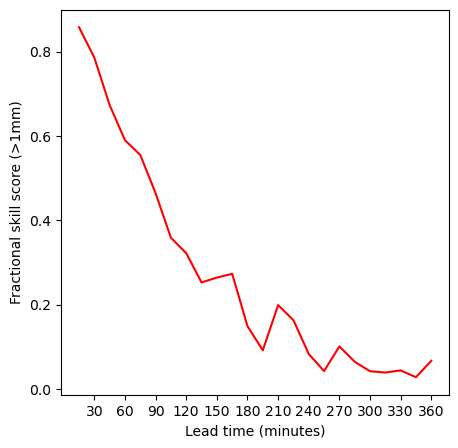

In [244]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot([15*n for n in range(24)], np.nanmean(total_fss, axis=0), color = 'red', label = '20 km')
ax.set_xticks([15+30*n for n in range(0,12)])
ax.set_xticklabels([30*n for n in range(1,13)])
ax.set_xlabel('Lead time (minutes)')
ax.set_ylabel('Fractional skill score (>1mm)')
#plt.savefig('29012024_morning_avg_fss.png', bbox_inches='tight')
plt.show()

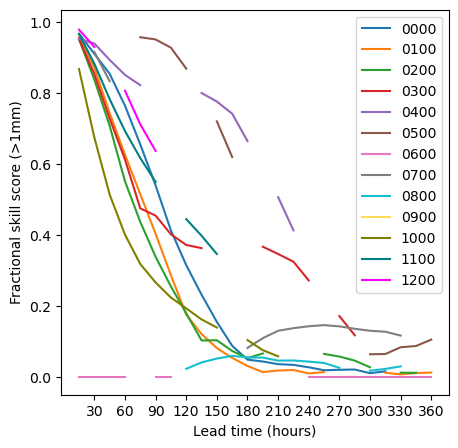

In [245]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

matplotlib_color_codes = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#17becf',  # Cyan
    '#ffdb58',  # Yellow
    '#808000',  # Olive
    '#008080',  # Teal
    '#ff00ff'   # Magenta
]

for i in range(total_fss.shape[0]):
    ax.plot([15*n for n in range(24)], total_fss[i], color = matplotlib_color_codes[i], label = init_times[i])  

ax.set_xticks([15+30*n for n in range(0,12)])
ax.set_xticklabels([30*n for n in range(1,13)])
ax.set_xlabel('Lead time (hours)')
ax.set_ylabel('Fractional skill score (>1mm)')
plt.legend()
#plt.savefig('29012024_morning_init_fss.png', bbox_inches='tight')
plt.show()

In [279]:
all_pred = []
all_obs = []
all_times = []

for j, init_time in enumerate(init_times):

    print(init_time)
    
    #dt_time = datetime.strptime(init_time, '%H%M')
    #obs_times = [datetime.strftime(dt_time + timedelta(minutes=15*n), '%H%M') for n in range(1,25)]

    obs_time = init_time
    
    pred_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_EXIM-CRR_MSG3_Africa-VISIR_' + date + 'T' + init_time + '00Z_120.nc']
    obs_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_CRR_MSG3_Africa-VISIR_' + date + 'T' + init_time + '00Z.nc' for obs in obs_times]

    for i in range(len(pred_files)):
    
        try:
 
            pred = xr.open_dataset(pred_files[i])
            obs = xr.open_dataset(obs_files[i])
    
            pred_array,_,_ = generate_array(pred)
            obs_array,_,_ = generate_array(obs)    
        
            if np.isnan(obs_array).any() == False:
                all_pred.append(pred_array)
                all_obs.append(obs_array)
                all_times.append(obs_time)
                

        except Exception as e:
            print(e)
            continue
            
all_pred = np.array(all_pred) 
all_obs = np.array(all_obs) 

0000
0100
0200
0300
0400
0500
0600
0700
0800
0900
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_EXIM-CRR_MSG3_Africa-VISIR_20240129T090000Z_120.nc'
1000
1100
1200


In [280]:
skill_map = fss_spatial(all_obs, all_pred, 1, 10)

/tmp/ipykernel_524/2232728429.py:50: RuntimeWarning: invalid value encountered in divide
  fss = 2*(O_F/O2_F2)


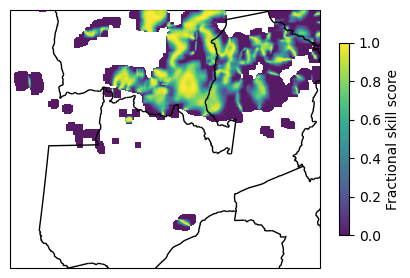

In [281]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))

img = ax.imshow(
    skill_map, origin='lower',
    extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
    zorder=10,
    alpha = 0.9
)

ax.add_feature(cfeature.BORDERS, zorder=10)
ax.coastlines(zorder=10)
plt.colorbar(img, shrink=0.5, label='Fractional skill score')

AttributeError: 'AxesImage' object has no attribute 'max'

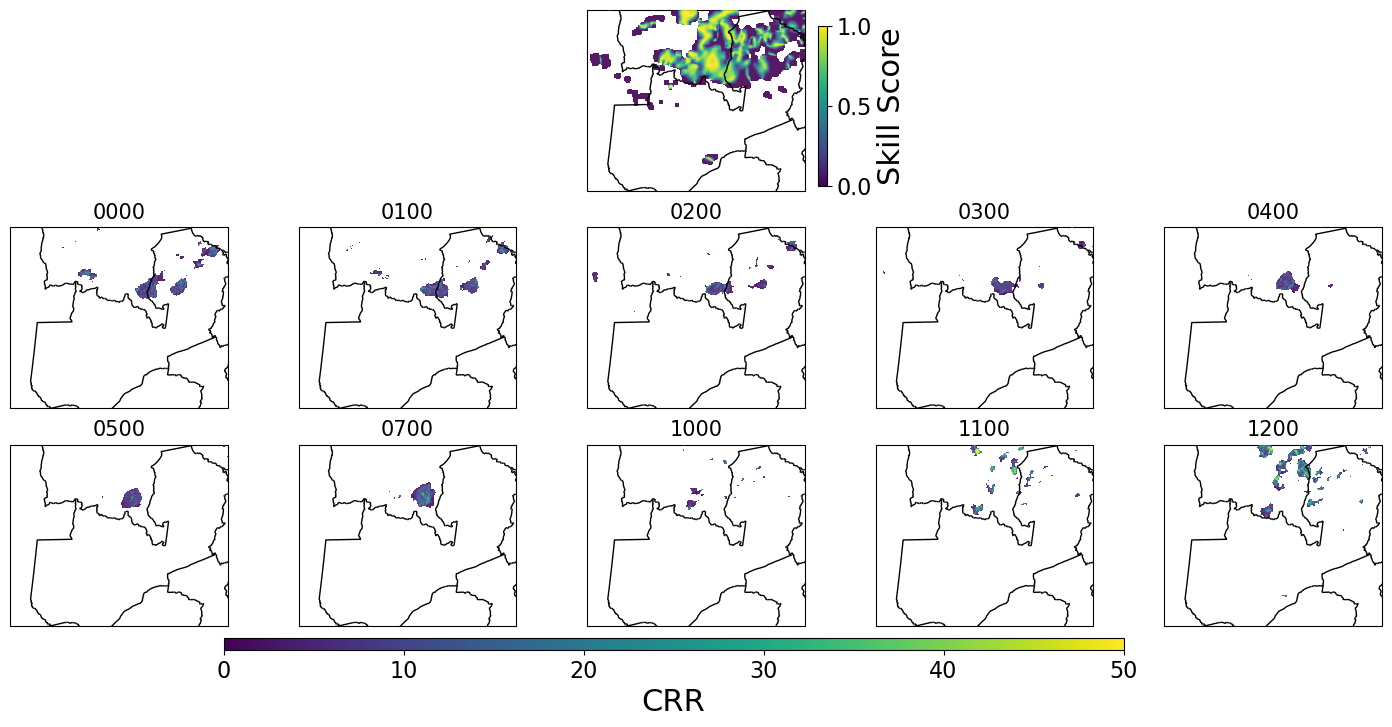

In [312]:
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(3,5,3,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))

img = ax.imshow(
    skill_map, origin='lower',
    extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
    zorder=10,
    alpha = 0.9
)

ax.add_feature(cfeature.BORDERS, zorder=10)
ax.coastlines(zorder=10)

cbar_ax = fig.add_axes([0.58, 0.66, 0.005, 0.2])
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), cax=cbar_ax, orientation='vertical')
cbar.set_label(label='Skill Score', size=22)
cbar.ax.tick_params(labelsize=16)

#plt.colorbar(img, shrink=0.5, label='Fractional skill score')

for i in range(10):
    
    ax = fig.add_subplot(3,5,5+i+1,projection=ccrs.Geostationary(central_longitude=0.0,satellite_height=35785831))
    
    img = ax.imshow(
        np.where(all_obs[i]==0,np.nan,all_obs[i]), origin='lower',
        extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
        zorder=10,
        alpha = 0.9
    )
    plt.title(all_times[i], fontsize=15)
    
    ax.add_feature(cfeature.BORDERS, zorder=10)
    ax.coastlines(zorder=10)

#plt.colorbar(img, shrink=0.8, label='CRR')
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.015])
norm = mpl.colors.Normalize(vmin=np.nanmin(all_obs), vmax=np.nanmax(all_obs))
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), cax=cbar_ax, orientation='horizontal')
cbar.set_label(label='CRR', size=22)
cbar.ax.tick_params(labelsize=16)

plt.savefig('29012024_morning_spatial_skill_score.png', bbox_inches='tight')

## Single time

In [183]:
date = '20240129'
init_time = '0400'

In [220]:
dt_time = datetime.strptime(init_time, '%H%M')
obs_times = [datetime.strftime(dt_time + timedelta(minutes=15*n), '%H%M') for n in range(1,25)]
lead_times = ["{:03d}".format(15*n) for n in range(1,25)]

pred_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_EXIM-CRR_MSG3_Africa-VISIR_' + date + 'T' + init_time + '00Z_' + lead + '.nc' for lead in lead_times]
obs_files = ['/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/' + date + '/CRR/S_NWC_CRR_MSG3_Africa-VISIR_' + date + 'T' + obs + '00Z.nc' for obs in obs_times]

f = [np.nan for i in range(24)]

for i in range(len(pred_files)):
    
    try:

        pred = xr.open_dataset(pred_files[i])
        obs = xr.open_dataset(obs_files[i])
    
        pred_array,_,_ = generate_array(pred)
        obs_array,_,_ = generate_array(obs)    
        
        if np.isnan(obs_array).any() == True:
            f[i] = np.nan
        else:
            fss_score = fss(1, 10, pred_array, obs_array)
            f[i] = fss_score

    except Exception as e:
        print(e)

[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T053000Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T084500Z.nc'
[Errno 2] No such file or directory: b'/gws/nopw/j04/swift/WISER-EWSA/Leeds_CRR/data/20240129/CRR/S_NWC_CRR_MSG3_Africa-VISIR_20240129T093000Z.nc'


In [233]:
pred = xr.open_dataset(pred_files[10])
obs = xr.open_dataset(obs_files[10])
    
pred_array,_,_ = generate_array(pred)
obs_array,_,_ = generate_array(obs) 

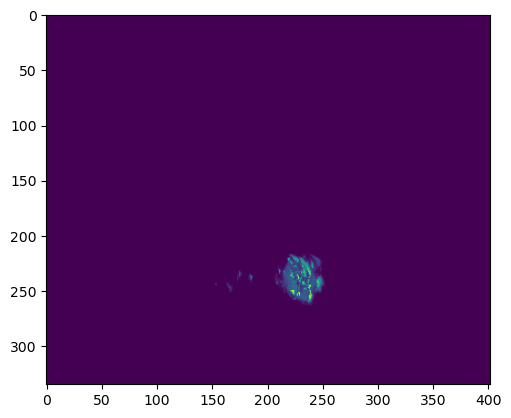

In [234]:
plt.imshow(obs_array)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


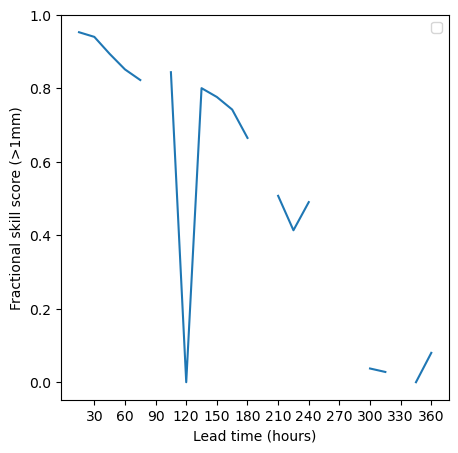

In [219]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.plot([15*n for n in range(24)], f)  

ax.set_xticks([15+30*n for n in range(0,12)])
ax.set_xticklabels([30*n for n in range(1,13)])
ax.set_xlabel('Lead time (hours)')
ax.set_ylabel('Fractional skill score (>1mm)')
plt.legend()
plt.show()